In [1]:
import config

from data_loader import *
import warnings
warnings.simplefilter("ignore", UserWarning)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from config import *
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
import pydicom
from torch.nn import BCEWithLogitsLoss,CrossEntropyLoss

C:\Users\cb102\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name = config.VERSION + '.pth'

complete_model_path = config.MODEL_FOLDER + model_name
binary = True
print(complete_model_path)

OUTPUT/Model/unet_10_27_v1.pth


In [4]:
unet = torch.load(complete_model_path)
unet = unet.to(config.DEVICE)
lossFunc = BCEWithLogitsLoss()
unet.eval()

U_net(
  (encoder): Encoder(
    (encBlocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (dropout): Dropout(p=0.25, inplace=False)
      )
      (1): Block(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (dropout): Dropout(p=0.25, inplace=False)
      )
      (2): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchN

In [8]:
test_img = ['DATASET/Prostatex-0000/t2_tse_tra/IM-0002-0010.dcm',
            'DATASET/Prostatex-0001/t2_tse_tra/IM-0007-0009.dcm',
            'DATASET/Prostatex-0002/t2_tse_tra/IM-0010-0007.dcm']
test_mask = ['DATASET/Prostatex-0000/mask/IM-0002-0010.png',
             'DATASET/Prostatex-0001/mask/IM-0007-0009.png',
             'DATASET/Prostatex-0002/mask/IM-0010-0007.png']
test_data = dataset_preperation(test_img, test_mask, False)
test_dataset = test_data.read_preprocess_dicom_mask('both', binary, True)

img, mask = test_dataset[0], test_dataset[1]

Loading and Processing datasets for Testing...
...


3it [00:02,  1.25it/s]

Loading images and masks finished.
Total amount of samples: 3
...


In [23]:
transformation = True
data = FetchImage(img, mask, transformation)

loader = DataLoader(data, shuffle=True, batch_size=config.BATCH_SIZE,
                          pin_memory=config.PIN_MEMORY, num_workers=4)

tensor(-4.8626, device='cuda:0')


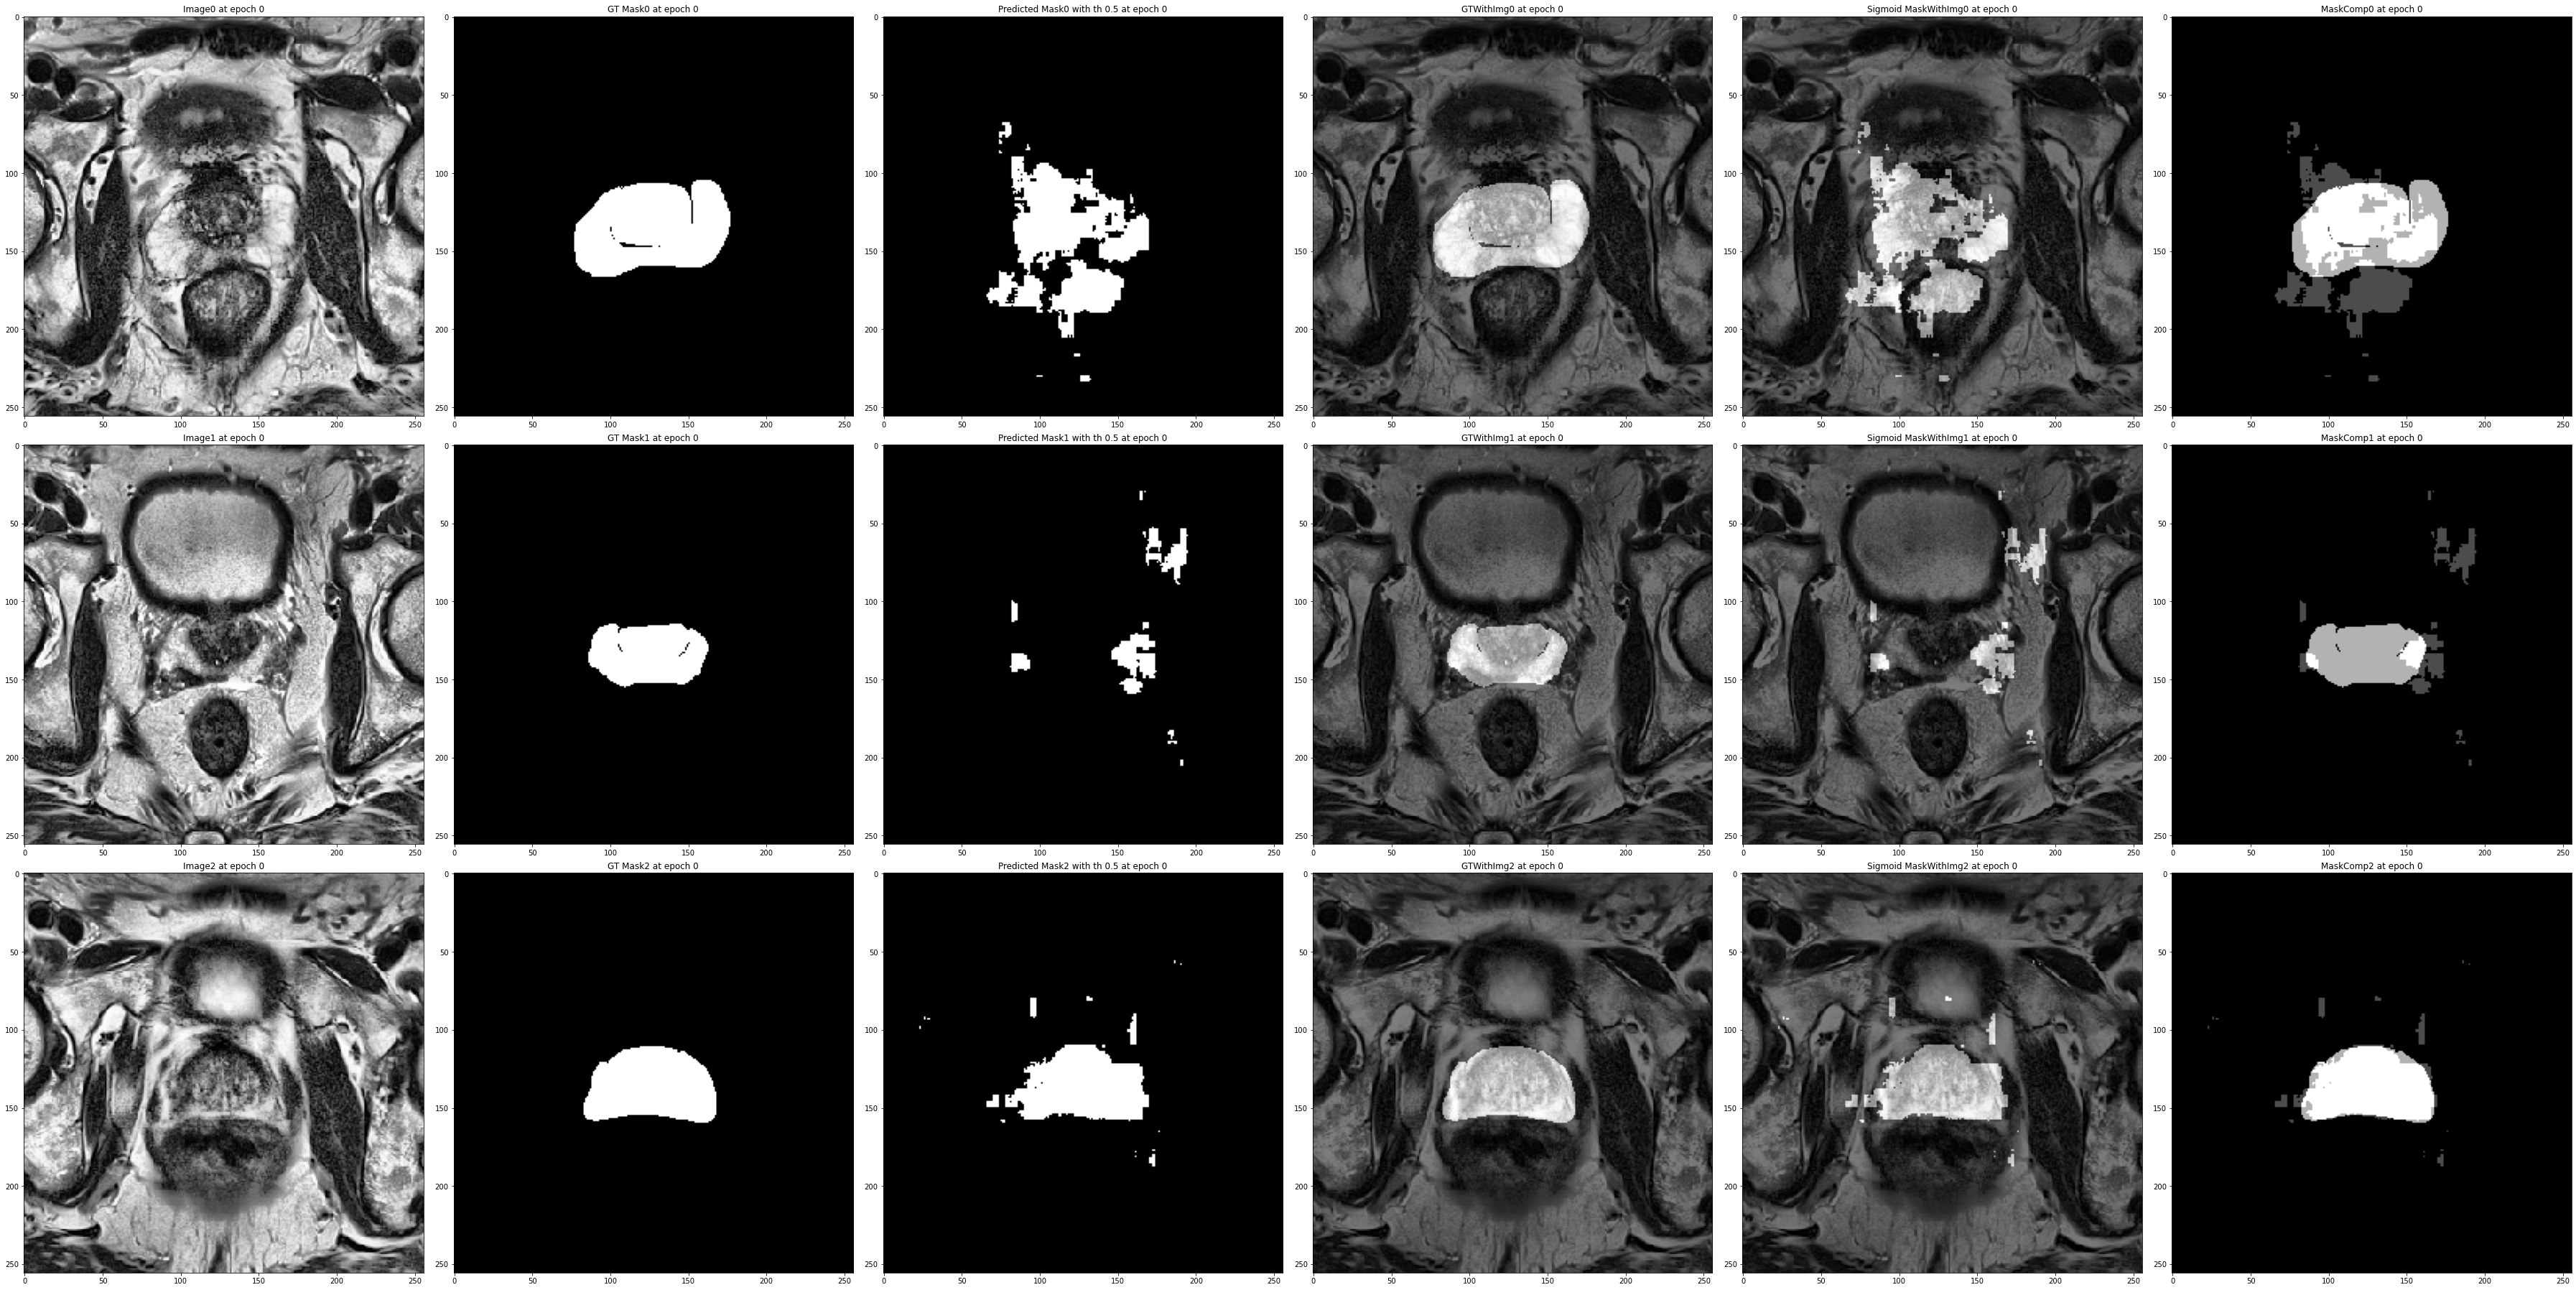

In [43]:
with torch.no_grad():
    for (i,(x,y)) in enumerate(loader):
        (x,y) = (x.to(config.DEVICE), y.to(config.DEVICE))
        pred = unet(x)

        print(lossFunc(pred,y.float()))
        p(x,pred,y,0,'', False)

In [42]:
def mask_img(mask,img):
    idx = np.where(mask!=0)
    mask[idx[0],idx[1]] = 255
    
    weighted_img = cv2.addWeighted(img,0.7,mask.astype(np.float32),0.3,0)
    weighted_img = cv2.addWeighted(weighted_img,0.7,mask.astype(np.float32),0.3,0)
    return weighted_img
def mask_diff(pred,gt):
    idx = np.where(pred != 0)
    pred[idx[0],idx[1]] = 255
    weighted_img = cv2.addWeighted(gt,0.7,pred.astype(np.int64),0.3,0)
    return weighted_img
def p(x,pred,y,epoch,plot_folder_predict,train):
    N = x.size()[0]
    fig,ax = plt.subplots(N,6,figsize=(50, 25))
    fig.tight_layout()
    for i in range(N):
        x_numpy = x[i][0].cpu().numpy() * 255
        y_numpy = y[i][0].cpu().detach().numpy()
        pred_sample = pred[i][0]
        pred_numpy = pred_sample.cpu().detach().numpy()
        pred_sigmoid = Sigmoid()(pred_sample).cpu().detach().numpy()
        pred_sigmoid_th = ((pred_sigmoid > THRESHOLD) * 255)
        gt_mask_img = mask_img(y_numpy,x_numpy)
        pred_mask_img = mask_img(pred_sigmoid_th,x_numpy)
        mask_comp = mask_diff(pred_sigmoid_th,y_numpy)
        
        ax[i,0].imshow(x_numpy,cmap = 'gray')
        ax[i,0].set_title(f'Image{i} at epoch {epoch}')
        ax[i,1].imshow(y_numpy, cmap='gray')
        ax[i,1].set_title(f'GT Mask{i} at epoch {epoch}')
        ax[i,2].imshow(pred_sigmoid_th, cmap='gray')
        ax[i,2].set_title(f'Predicted Mask{i} with th 0.5 at epoch {epoch}')
        ax[i,3].imshow(gt_mask_img, cmap='gray')
        ax[i,3].set_title(f'GTWithImg{i} at epoch {epoch}')
        ax[i,4].imshow(pred_mask_img, cmap='gray')
        ax[i,4].set_title(f'Sigmoid MaskWithImg{i} at epoch {epoch}')
        ax[i,5].imshow(mask_comp, cmap='gray')
        ax[i,5].set_title(f'MaskComp{i} at epoch {epoch}')
    plt.show()

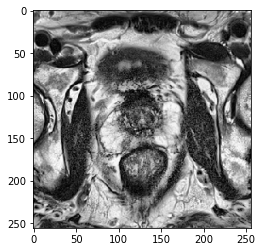

In [11]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

In [ ]:
plot_folder_predict = config.PLOT_FOLDER + config.VERSION + '/predict/'
if not os.path.isdir(plot_folder_predict):
    os.makedirs(plot_folder_predict)

In [28]:
with torch.no_grad():
    for (i,(x,y)) in enumerate(loader):
        (x,y) = (x.to(config.DEVICE), y.to(config.DEVICE))
        pred = unet(x)

        print(lossFunc(pred,y.float()))
        config.plot_figure(x,pred,y,0,plot_folder_predict, False)

torch.Size([1, 64, 64])

In [44]:

from prostate_seg import *
binary = True
encChannels = [1, 16, 32, 64, 128]
decChannels = [128, 64, 32, 16]
unet = U_net(encChannels = encChannels,
                 decChannels = decChannels, binary= binary)
unet.eval()

U_net(
  (encoder): Encoder(
    (encBlocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (dropout): Dropout(p=0.25, inplace=False)
      )
      (1): Block(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (dropout): Dropout(p=0.25, inplace=False)
      )
      (2): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchN